<center> <a href = Frameworks.ipynb>ML Framework Use &lt;</a> | <a href = Visualizations.ipynb>&gt; Visualizations</a> <center>

# What types of ML models are people using?
All results within the context of machine learning with sklearn.


## Results Summary:
- Supervised learning is much more common than unsupervised learning.
- Within supervised models, linear models are the most common, followed by ensemble methods.
- Within unsupervised models, decomposition is the most popular, followed by clustering.
-----------------

# Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import datetime

import load_data

Load dataframes

In [2]:
notebooks_temp = load_data.load_notebooks()
repos_temp = load_data.load_repos()

Notebooks loaded in 0:00:27.164260
Repos loaded in 0:00:04.586144


Load aggregated dataframe. Code used to create it is in [aggregate.py](aggregate.py).

In [3]:
framework_uses_df_temp = load_data.load_framework_uses()

Framework uses loaded in 0:00:19.179276


---
# Tidy Data

### Only looking at Python notebooks

In [4]:
notebooks = notebooks_temp.copy()[notebooks_temp.lang_name == 'python'].reset_index(drop=True)

In [5]:
print("{0:,} ({1}%) of notebooks not in ipynb checkpoints were written in Python. The remaining {2}% have been removed.".format(
    len(notebooks),
    round(100*len(notebooks)/len(notebooks_temp), 2),
    round(100 - 100*len(notebooks)/len(notebooks_temp), 2)
))

4,403,851 (95.95%) of notebooks not in ipynb checkpoints were written in Python. The remaining 4.05% have been removed.


### Update repos and aggregated dataframe to reflect notebooks in question

In [6]:
repos = repos_temp.copy()[repos_temp.repo_id.isin(notebooks.repo_id)].reset_index(drop=True)
framework_uses_df = framework_uses_df_temp.copy()[framework_uses_df_temp.file.isin(notebooks.file)].reset_index(drop=True)

In [7]:
len(framework_uses_df)

4032671

### Delete temp dataframes to save space

In [8]:
del notebooks_temp
del framework_uses_df_temp

---
# Manipulate Data

### Supervised vs unsupervised models

In [9]:
model_to_type = {
    'sklearn.linear_model': 'S',
    'sklearn.discriminant_analysis': 'S',
    'sklearn.kernel_ridge': 'S',
    'sklearn.svm': 'S',
    'sklearn.SGDClassifier': 'S',
    'sklearn.neighbors': 'S',
    'sklearn.gaussian_process': 'S',
    'sklearn.cross_decomposition': 'S',
    'sklearn.naive_bayes': 'S',
    'sklearn.tree': 'S',
    'sklearn.ensemble': 'S',
    'sklearn.multiclass': 'S',
    'sklearn.feature_selection': 'S',
    'sklearn.semi_supervised': 'S',
    'sklearn.isotonic': 'S',
    'sklearn.calibration': 'S',
    'sklearn.neural_network': 'S',
    
    'sklearn.mixture': 'U',
    'sklearn.manifold': 'U',
    'sklearn.cluster': 'U',
    'sklearn.decomposition': 'U',
    'sklearn.covariance': 'U',
    #'sklearn.neural_network.BernoulliRBM': 'U'
}

In [10]:
all_supervised = []
all_unsupervised = []
sklearn_uses = []
for framework_uses in framework_uses_df.uses:
    nb_sklearn_uses = []
    for framework in framework_uses:
        if framework == 'sklearn':
            for use in framework_uses[framework]:
                major = '.'.join(use.split('.')[:2])
                if major in model_to_type:
                    t = model_to_type[major]
                    if t == 'S':
                        if use.startswith('sklearn.neural_network.BernoulliRBM'):
                            all_unsupervised.append(major)
                            nb_sklearn_uses.append(major)
                        else:
                            all_supervised.append(major)
                            nb_sklearn_uses.append(major)
                    else:
                        all_unsupervised.append(major)
                        nb_sklearn_uses.append(major)
    sklearn_uses.append(nb_sklearn_uses)
    
framework_uses_df['sklearn_models'] = sklearn_uses

In [11]:
start = datetime.datetime.now()
for model in set(load_data.flatten(framework_uses_df.sklearn_models)):
    framework_uses_df[model] = [model in m for m in framework_uses_df.sklearn_models]
    print(model, datetime.datetime.now() - start)
end = datetime.datetime.now()
print(end - start)

sklearn.isotonic 0:00:01.850465
sklearn.svm 0:00:02.807017
sklearn.mixture 0:00:03.759447
sklearn.gaussian_process 0:00:04.795323
sklearn.ensemble 0:00:05.742584
sklearn.semi_supervised 0:00:06.683217
sklearn.covariance 0:00:07.648049
sklearn.feature_selection 0:00:08.593797
sklearn.kernel_ridge 0:00:09.571501
sklearn.tree 0:00:10.512974
sklearn.multiclass 0:00:11.454837
sklearn.cluster 0:00:12.396466
sklearn.discriminant_analysis 0:00:13.338296
sklearn.manifold 0:00:14.290468
sklearn.naive_bayes 0:00:15.237236
sklearn.decomposition 0:00:16.178272
sklearn.cross_decomposition 0:00:17.120547
sklearn.neighbors 0:00:18.059118
sklearn.calibration 0:00:19.019801
sklearn.linear_model 0:00:19.956215
sklearn.neural_network 0:00:20.900219
0:00:20.900747


In [12]:
all_s_counts = pd.Series(all_supervised).value_counts().reset_index().rename(
    columns = {'index':'model',0:'count'}
)
all_u_counts = pd.Series(all_unsupervised).value_counts().reset_index().rename(
    columns = {'index':'model',0:'count'}
)

### Model use over time

In [13]:
# 40 seconds
start = datetime.datetime.now()

framework_uses_time_df = framework_uses_df.merge(
    notebooks[['file','repo_id']], on = 'file'
).merge(
    repos[['repo_id','pushed_at']], on = 'repo_id'
)

framework_uses_time_df['pushed_at'] = pd.to_datetime(framework_uses_time_df['pushed_at'])
framework_uses_time_df['month'] = [c.month for c in framework_uses_time_df['pushed_at']]
framework_uses_time_df['year'] = [c.year for c in framework_uses_time_df['pushed_at']]

end = datetime.datetime.now()
print(end - start)

0:00:55.344719


In [14]:
start = datetime.datetime.now()

top_models = [
    'linear_model',
    'ensemble',
    'tree',
    'svm',
    'neighbors',
    'decomposition',
    'cluster'
]

for m in top_models:
    framework_uses_time_df[m] = [
        'sklearn' in u and m in [
            s.split('.')[1] for s in u['sklearn'] if '.' in s
        ]
        for u in framework_uses_time_df['uses']
    ]
    print(m, datetime.datetime.now() - start)
    
end = datetime.datetime.now()
print(end - start)

linear_model 0:00:03.416755
ensemble 0:00:06.833278
tree 0:00:10.215885
svm 0:00:13.585849
neighbors 0:00:17.055510
decomposition 0:00:20.517550
cluster 0:00:23.896600
0:00:23.896911


In [15]:
framework_uses_nb_time_df = framework_uses_time_df.groupby(
    ['month','year']
)[top_models].sum().reset_index().merge(
    framework_uses_time_df.groupby(
        ['month','year']
    )['file'].count().reset_index().rename(
        columns = {'file':'total'}
    )
).sort_values(['year','month'])

framework_uses_nb_time_df['order'] = list(range(len(framework_uses_nb_time_df)))
framework_uses_nb_time_df['label'] = [
        datetime.date(int(row['year']), int(row['month']), 1).strftime('%b %Y') 
        if row['month'] == 1 else ''
        for _, row in framework_uses_nb_time_df.iterrows()
    ]

---
# Visualizations and Statistics

## Framework use

In [16]:
sk_uses = sum([sum([f.startswith('sklearn') 
                    for f in framework]) 
               for framework in framework_uses_df.uses])
tf_uses = sum([sum([f.startswith('tensorflow') 
                    for f in framework]) 
               for framework in framework_uses_df.uses])
keras_uses = sum([sum([f.startswith('keras') 
                    for f in framework]) 
               for framework in framework_uses_df.uses])

all_uses = sk_uses + tf_uses + keras_uses

print("There are: \n{0} ({1}%) notebooks using SciKitLearn \n{4} ({5}%) notebooks using Keras \n{2} ({3}%) notebooks using Tensorflow".format(
    sk_uses, round(100*sk_uses/all_uses, 2), tf_uses, round(100*tf_uses/all_uses, 2), keras_uses, round(100*keras_uses/all_uses, 2)
))

There are: 
991246 (63.11%) notebooks using SciKitLearn 
243535 (15.5%) notebooks using Keras 
335909 (21.39%) notebooks using Tensorflow


SciKitLearn is the most popular machine learning framework for Jupyter notebooks, as we saw in exploring [frameworks](Frameworks.ipynb).

## Comparing supervised and unsupervised

### Focusing on SciKitLearn

SciKitLearn has good documentation of all available models, making it easy to distinguish what model a user is deploying. On the other hand, Keras and Tensorflow have *parts* of models, called layers, that users can use to build different types of models. Keras is primarily for neural networks, and neural networks are primarily supervised learning. However, there are instances of using keras for unsupervised learning, and its very difficult to parse that information from the code itself. Tensorflow is even more difficult because it can use lots of different APIs (for instance, tensorflow can actually use keras). For these reasons, and because the majority of machine learning uses are SciKitLearn, I have decided to focus on SciKitLearn models for this section.

References
- [sklearn supervised](https://scikit-learn.org/stable/supervised_learning.html)
- [sklearn unsupervised](https://scikit-learn.org/stable/unsupervised_learning.html)


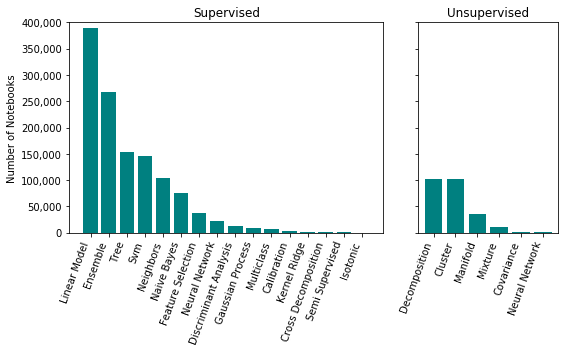

In [23]:
fig = plt.figure(figsize=(8, 5))

x = [' '.join(m.split('.')[1].title().split('_')) for m in all_s_counts['model']]
x_pos = np.arange(len(x))
height = all_s_counts['count']
ax0 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax0.bar(x_pos, height, color = 'teal')
plt.title('Supervised')
plt.xticks(x_pos, x, rotation = 70, ha = 'right')
plt.ylim(0, 400000)
plt.yticks(range(0, 400001, 50000), ['{:,}'.format(i) for i in range(0, 400001, 50000)])
plt.ylabel('Number of Notebooks')



ax1 = plt.subplot2grid((1, 3), (0, 2))
x = [' '.join(m.split('.')[1].title().split('_')) for m in all_u_counts['model']]
x_pos = np.arange(len(x))
height = all_u_counts['count']
ax1.bar(x_pos, height, color = 'teal')
plt.title('Unsupervised')
plt.xticks(x_pos, x, rotation = 70, ha = 'right')
plt.ylim(0, 400000)
plt.yticks(range(0, 400001, 50000), ['' for i in range(0, 400001, 50000)])

plt.tight_layout()
plt.show()

Supervised learning is much more common than unsupervised learning. I'll go over the contents of the most common model groups. For a full list, view the sklearn [documentation](https://scikit-learn.org/stable/supervised_learning.html). 

Within supervised learning, linear models are the most common. This includes regular least squares regression, ridge and lasso regression, elastic net, logistic regression, stochastic gradient descent.

Closely following linear models are ensemble methods, which includes bagging, random forests, adaboost, gradient tree boosting, voting classifiers, and voting regressors.

Within unsupervised learning, decomposition is the most popular. This includes PCA, singular value decomposition, dictionary learning, factor analysis, independent component analysis, non-negative matrix factorization, and latent dirichlet allocation.

Following decomposition is clustering, which incorperates k means, mean shift, hierarchical, dbscan, and more.

## Are some sklearn models likely to be used in the same notebooks?

In [18]:
corr = framework_uses_df[set(load_data.flatten(framework_uses_df.sklearn_models))].corr()

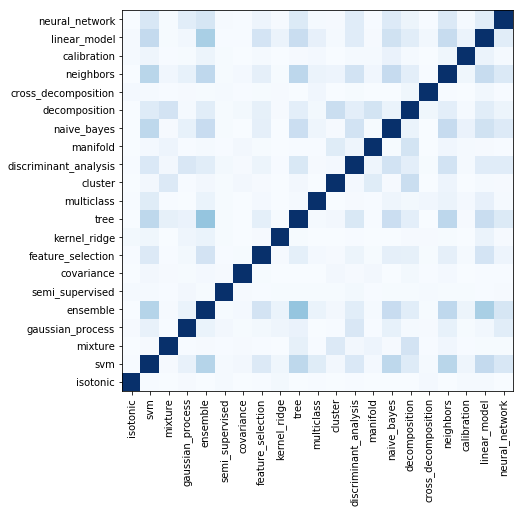

In [19]:
fig = plt.figure(figsize = (7,7))
plt.pcolor(corr, cmap = 'Blues')
plt.yticks(np.arange(0.5, len(corr.index), 1), [c.split('.')[1] for c in corr.index])
plt.xticks(np.arange(0.5, len(corr.columns), 1), [c.split('.')[1] for c in corr.columns], rotation = 90)
plt.show()

The strongest association is between tree and ensemble (r = 0.39), which makes sense as these can be used together. The next strongest is linear model and ensemble (r = 0.33) followed by svm and ensemble (r = 0.29), svm and neighbors (r = 0.28), and tree and neigbors (r = 0.27).

## Model type over time

In [20]:
def plot_model(model, since = 2012, color = None):
    df = framework_uses_nb_time_df[framework_uses_nb_time_df.year >= since]
    x_pos = df.order
    x = df.label
    y = df[model] / df.total

    if color != None:
        plt.plot(x_pos, y, label = model.title(), color = color)
    else:
        plt.plot(x_pos, y, label = model.title())
    plt.xticks(x_pos, x, rotation = 70)
    plt.title('Use of Scikit-Learn {0}'.format(' '.join(
        model.title().split('_')
    )))

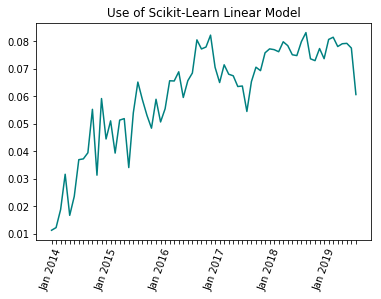

In [21]:
plot_model('linear_model', since = 2014, color= 'teal')
plt.show()

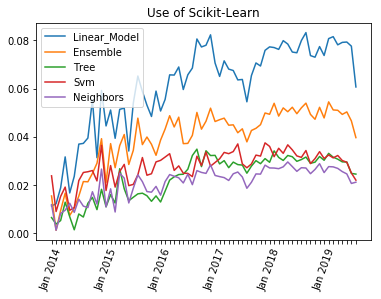

In [22]:
for m in [
    'linear_model',
    'ensemble',
    'tree',
    'svm',
    'neighbors'
]:
    plot_model(m, since = 2014)
    
plt.title('Use of Scikit-Learn')
plt.legend()

plt.show()

<center> <a href = Frameworks.ipynb>ML Framework Use &lt;</a> | <a href = Visualizations.ipynb>&gt; Visualizations</a> <center>